<a href="https://colab.research.google.com/github/DvoryadkinaDV/Using-neural-networks-to-generate-text/blob/main/OATD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Дворядкина
# Отчет ЛР3

**Импорт библиотек**

In [2]:
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


from random import sample
from IPython.display import clear_output
from torch.utils.data import DataLoader, TensorDataset

In [3]:
torch.cuda.is_available()

True

**Загрузим данные (Пушкин)**

In [4]:
!wget -O poems.txt http://uit.mpei.ru/git/main/TDA/raw/branch/master/assets/poems/pushkin.txt

--2024-04-12 17:34:34--  http://uit.mpei.ru/git/main/TDA/raw/branch/master/assets/poems/pushkin.txt
Resolving uit.mpei.ru (uit.mpei.ru)... 193.233.68.149
Connecting to uit.mpei.ru (uit.mpei.ru)|193.233.68.149|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1048627 (1.0M) [text/plain]
Saving to: ‘poems.txt’

poems.txt           100%[===================>]   1.00M   596KB/s    in 1.7s    

2024-04-12 17:34:36 (596 KB/s) - ‘poems.txt’ saved [1048627/1048627]



In [5]:
# Загружаем текст из файла.
# Стихотворения в файле разделены токеном '</s>'

with open("poems.txt") as file:
  data = file.read().split("</s>\n\n")
print(f"Количество стихов: {len(data)}\n", f"Пример стиха:\n\n{data[10]}",  sep="\n")

Количество стихов: 720

Пример стиха:

Возможно ль? вместо роз, Амуром насажденных,
Тюльпанов гордо наклоненных,
Душистых ландышей, ясминов и лилей,
Которых ты всегда любила
И прежде всякой день носила
На мраморной груди твоей —
Возможно ль, милая Климена,
Какая странная во вкусе перемена!..
Ты любишь обонять не утренний цветок,
А вредную траву зелену,
Искусством превращенну
В пушистый порошок! —
Пускай уже седой профессор Геттингена,
На старой кафедре согнувшися дугой,
Вперив в латинщину глубокой разум свой,
Раскашлявшись, табак толченый
Пихает в длинный нос иссохшею рукой;
Пускай младой драгун усатый
Поутру, сидя у окна,
С остатком утреннего сна,
Из трубки пенковой дым гонит сероватый;
Пускай красавица шестидесяти лет,
У Граций в отпуску, и у любви в отставке,
Которой держится вся прелесть на подставке,
Которой без морщин на теле места нет,
Злословит, молится, зевает
И с верным табаком печали забывает, —
А ты, прелестная!.. но если уж табак
Так нравится тебе – о пыл воображенья! —
Ах

**Подготовка данных и сводные статистики**

In [6]:
# Составляем словарь уникальных токенов
vocab = ["PAD", "EOS",] + list(set("".join(data))) #список уникальных символов.

# Формируем два словаря, реализующие перевод символов в их индексы и обратно
id2char = dict(enumerate(vocab)) #словарь индексов в символы
char2id = {char: ind for ind, char in id2char.items()} #словарь символов в индексы
print(f"Количество уникальных символов: {len(vocab)}", id2char, sep="\n")

Количество уникальных символов: 143
{0: 'PAD', 1: 'EOS', 2: 'И', 3: 'Е', 4: 'ê', 5: 'S', 6: 'р', 7: 'к', 8: '_', 9: 'о', 10: 'p', 11: 'h', 12: 'â', 13: 'Ю', 14: 'a', 15: 't', 16: 'O', 17: 'н', 18: 'ы', 19: 'П', 20: 'д', 21: '„', 22: 'u', 23: '«', 24: 'в', 25: 'М', 26: 'y', 27: 'R', 28: 'û', 29: 'Х', 30: 'ô', 31: '–', 32: 'k', 33: 'Я', 34: 'х', 35: '…', 36: 'б', 37: 'ъ', 38: 'г', 39: 'n', 40: 'x', 41: 'd', 42: 'Р', 43: 'я', 44: '»', 45: 'D', 46: 'ч', 47: 'у', 48: '"', 49: 'C', 50: 'I', 51: 'Й', 52: 'g', 53: 'ю', 54: 'l', 55: 'j', 56: 'п', 57: 'c', 58: 'Б', 59: 'Л', 60: 'м', 61: ';', 62: 'ё', 63: '-', 64: 'й', 65: "'", 66: 'P', 67: '*', 68: 'Ж', 69: 'H', 70: 'ф', 71: 'è', 72: '\n', 73: ':', 74: 'А', 75: 'У', 76: 'с', 77: 's', 78: 'i', 79: 'v', 80: 'Д', 81: 'Г', 82: 'т', 83: 'К', 84: 'J', 85: '.', 86: 'N', 87: 'ь', 88: ')', 89: ' ', 90: 'Щ', 91: ',', 92: 'э', 93: '\xa0', 94: 'ç', 95: 'л', 96: '!', 97: '<', 98: 'Т', 99: 'à', 100: 'ж', 101: 'Н', 102: 'ц', 103: 'Э', 104: 'e', 105: 'b', 106: 

In [7]:
lengths = list(map(len, data))
print("Максимальная длина текста: ", max(lengths))

Максимальная длина текста:  8948


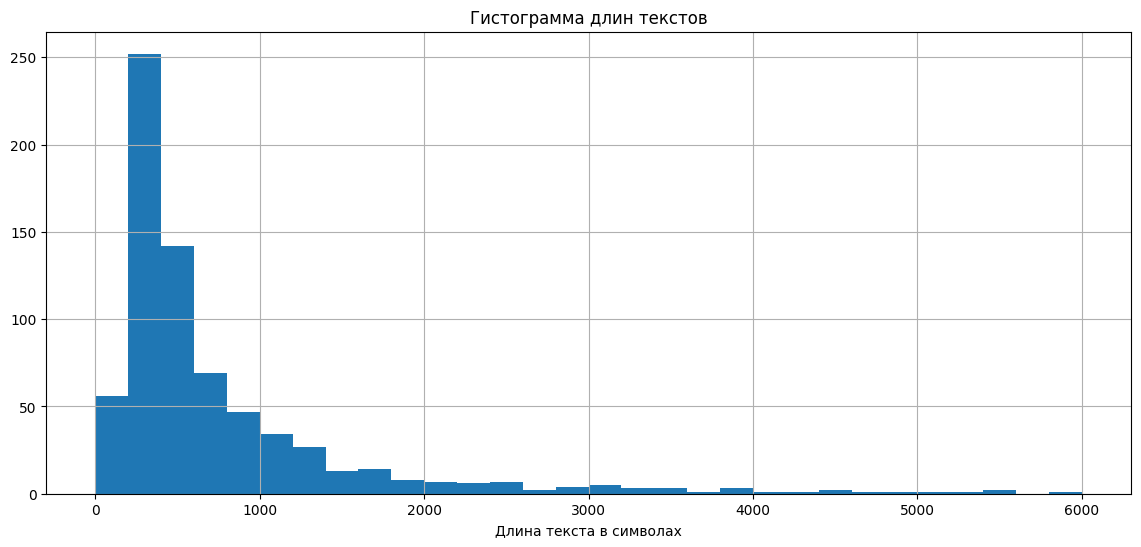

In [8]:
plt.rcParams["figure.figsize"] = (14, 6)
plt.hist(lengths, bins=30, range=[0, 6000])
plt.xlabel("Длина текста в символах")
plt.title("Гистограмма длин текстов")
plt.grid()

In [9]:
lengths = np.array(lengths)
print("Средняя длина", np.mean(lengths))
print("Медиана длины", np.median(lengths))
print("Мода длины", np.bincount(lengths).argmax())

Средняя длина 808.9125
Медиана длины 453.5
Мода длины 221


Где можно будет использовать знание о параметрах распределения длин в выборке?

In [43]:
# Устанавливаем, сколько символов будет генерировать модель (максимальная длина генерируемого текста)
MAXLEN = 500

**Преобразование данных**

In [44]:
line_ix = [char2id[c] for c in data[5][:500]]

In [45]:
data_ix = np.zeros([len(data[5]), 500], 'int64')
data_ix[5, :len(line_ix)] = line_ix

In [46]:
data_ix= np.transpose(data_ix)
print(data_ix[5])

[0 0 0 ... 0 0 0]


In [47]:
def to_matrix(data, char2id, max_len=None, dtype='int64', batch_first = True):

    max_len = max_len if max_len else max(map(len, data))
    data = [text[:max_len] for text in data]
    data_ix = np.zeros([len(data), max_len+1], dtype)

    for i in range(len(data)):
        line_ix = [char2id[c] for c in data[i][:max_len]] + [char2id["EOS"]]
        data_ix[i, :len(line_ix)] = line_ix

    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [48]:
# Проверяем работу функции - кодируем один из текстов и смотрим как он выглядит в кодированном виде
encode = to_matrix(data[:1], char2id, MAXLEN)
print("Исходный текст:\n", data[0])
print("Преобразованный текст:\n", encode[0])

Исходный текст:
 Так и мне узнать случилось,
Что за птица Купидон;
Сердце страстное пленилось;
Признаюсь – и я влюблен!
Пролетело счастья время,
Как, любви не зная бремя,
Я живал да попевал,
Как в театре и на балах,
На гуляньях иль в воксалах
Легким зефиром летал;
Как, смеясь во зло Амуру,
Я писал карикатуру
На любезный женской пол;
Но напрасно я смеялся,
Наконец и сам попался,
Сам, увы! с ума сошел.
Смехи, вольность – всё под лавку
Из Катонов я в отставку,
И теперь я – Селадон!
Миловидной жрицы Тальи
Видел прелести Натальи,
И уж в сердце – Купидон!

Так, Наталья! признаюся,
Я тобою полонен,
В первый раз еще, стыжуся,
В женски прелести влюблен.
Целый день, как ни верчуся
Лишь тобою занят я;
Ночь придет – и лишь тебя
Вижу я в пустом мечтаньи,
Вижу, в легком одеяньи
Будто милая со мной;
Робко, сладостно дыханье,
Белой груди колебанье,
Снег затмивший белизной,
И полуотверсты очи,
Скромный мрак безмолвной ночи —
Дух в восторг приводят мой!..
Я один в беседке с нею,
Вижу… девственну лилею,


**Пояснить, что хранится в переменной encode.**

Переменная encode - вызывает функцию to_matrix для кодирования первого текста из списка data, используя словарь char2id, каждый символ текста заменяется на соответствующий ему числовой индекс из словаря char2id, и длина каждой строки задается максимальной длиной последовательности MAXLEN.


**Как будет выглядеть ваша фамилия в кодированном виде?**

In [49]:
name = 'Dvoryadkina'
encode = to_matrix(name, char2id, 5)
print("Исходный текст:\n", name)
print("Преобразованный текст:\n", encode)

Исходный текст:
 Dvoryadkina
Преобразованный текст:
 [[ 45   1   0   0   0   0]
 [ 79   1   0   0   0   0]
 [112   1   0   0   0   0]
 [135   1   0   0   0   0]
 [ 26   1   0   0   0   0]
 [ 14   1   0   0   0   0]
 [ 41   1   0   0   0   0]
 [ 32   1   0   0   0   0]
 [ 78   1   0   0   0   0]
 [ 39   1   0   0   0   0]
 [ 14   1   0   0   0   0]]


**Подготовка нейросети**

In [50]:
num_embeddings = len(vocab) #количество эмбеддингов должно соответствовать длине словаря
embedding_dim = 32 #определяется размерность эмбеддинга
emb = nn.Embedding(num_embeddings, embedding_dim) # Определяем объект emb как слой эмбеддингов заданного размера

In [55]:
num_embeddings

143

**Почему количество эмбеддингов должно соответствовать длине словаря?**

 Либо будет недостаточно информации для представления всех слов или символов, либо будет избыточная информация, что может привести к переобучению модели. Это связано с тем, что каждый уникальный элемент должен иметь свое собственное представление в пространстве эмбеддингов.

**В качестве примера пропустим через этот слой первые 5 букв первого текста.**

In [52]:
# emb_out - 5 первых символов в виде эмбедингов
emb_out = emb(torch.tensor(encode[0][:5]))
print(f"Размер тензора: {emb_out.shape}\n")
print(emb_out)

Размер тензора: torch.Size([5, 32])

tensor([[ 2.1419e+00,  6.4880e-01, -5.0542e-01, -9.0028e-02,  3.3631e-01,
         -5.3598e-01,  6.6615e-01,  1.0326e+00,  4.0378e-02,  6.9436e-01,
         -3.1785e-01,  8.7901e-01, -7.7673e-01,  1.5005e-01,  1.1707e+00,
          1.1007e+00, -7.2402e-02,  9.3015e-01,  9.1894e-01, -1.5107e+00,
          2.3024e+00,  7.6099e-01, -3.7637e-01, -3.2740e-01, -1.0354e+00,
         -2.1420e-01, -4.8397e-01, -8.9674e-01, -1.6555e+00,  8.1808e-01,
         -2.8171e-01, -2.5328e-01],
        [-1.6618e-02, -4.7833e-01, -2.5751e-01, -9.0939e-01, -6.2905e-01,
          1.3572e+00, -1.3073e+00,  1.0538e-01,  4.4951e-01, -1.6170e+00,
          1.8275e+00,  7.3720e-01,  1.0262e+00, -1.8211e+00, -9.2707e-01,
          2.2508e-03,  9.9562e-02,  1.2520e+00, -8.7406e-01,  2.2867e-01,
          1.2801e+00,  5.4227e-03,  1.6581e+00,  7.5354e-01, -2.5530e-01,
          1.7971e+00, -9.0090e-01,  1.1381e-01, -9.0234e-01,  1.6030e+00,
         -7.5009e-01,  2.5997e-01],
   

**Пояснить, почему получен такой размер emb_out?**

Размер тензора: torch.Size([5, 32]) получается из того, что эмбеддинги применяются к первым пяти буквам из закодированной последовательности encode.  Каждая из пяти букв была преобразована в вектор размерности 32.

**Создадим ячейку GRU**

**Обратиться к документации к nn.GRU и ответить на вопрос, за что отвечают параметры input_size, hidden_size, num_layers.**

input_size - количество ожидаемых функций во входных данных

hidden_size - количество объектов в скрытом состоянии

num_layers - количество повторяющихся слоев. Например, num_layers=2 будет означать объединение двух GRU вместе для формирования составного GRU, при этом второй GRU принимает выходные данные первого GRU и вычисляет окончательные результаты. По умолчанию: 1

In [56]:
# Определяем ячейку GRU в переменной gru, предварительно задав рамерность скрытого состояния и количество рекуррентных слоев
input_size = emb.embedding_dim # вход в GRU должен соответствовать размеру эмбеддинга
hidden_size = 60 #<your choice here>
num_layers = 2 #<your choice here>
gru = nn.GRU(input_size, hidden_size, num_layers)
output, h_n = gru(emb_out)
print("Размер output:", output.shape)
print("Размер h_n:", h_n.shape)

Размер output: torch.Size([5, 60])
Размер h_n: torch.Size([2, 60])


In [57]:
in_features = gru.hidden_size
out_features = len(vocab) #предсказываем букву из всего словаря
linear = nn.Linear(in_features, out_features) # Определяем линейный слой. Почему заданы такие входные и выходные параметры для него?
linear_out = linear(output) # output - выход GRU
print("Размер выходного слоя из нейросети: ", linear_out.shape)

Размер выходного слоя из нейросети:  torch.Size([5, 143])


Входные данные для линейного слоя будут иметь размерность, соответствующую размерности скрытого состояния GRU. Это связано с тем, что выходной результат GRU имеет размерность скрытого состояния.


**Что содержится в векторе linear_out?**

**Определить индекс символа, который наиболее вероятно выдаст ячейка GRU на первом шаге?**

In [58]:
linear_out[0]

tensor([-0.0043, -0.0007, -0.0362, -0.0159, -0.0071,  0.0002,  0.0509,  0.0627,
        -0.0814,  0.0034, -0.0778,  0.0591, -0.0896,  0.0316,  0.1369,  0.0675,
        -0.0087, -0.1524, -0.0318, -0.0401, -0.1525,  0.1080, -0.1384, -0.0784,
        -0.1758, -0.1205,  0.0855,  0.0579, -0.0992,  0.0493, -0.0738,  0.0235,
        -0.0620, -0.0800,  0.1122, -0.0701,  0.0374,  0.0180,  0.1356, -0.1702,
         0.0282,  0.0286, -0.1289,  0.1529,  0.0255,  0.0748,  0.1436, -0.0092,
         0.0642, -0.0858, -0.0079, -0.0155, -0.0219, -0.0658, -0.1344,  0.1391,
         0.0760,  0.0289, -0.1153, -0.0643,  0.0411, -0.0747,  0.1270,  0.0322,
        -0.1005,  0.1021,  0.1283,  0.1571, -0.0082,  0.0827, -0.0755, -0.0406,
        -0.0879,  0.0803,  0.1369,  0.0102,  0.0591,  0.0874,  0.1204,  0.0193,
        -0.0397, -0.0364, -0.0663,  0.1528, -0.1286, -0.0020,  0.1204, -0.1363,
         0.0038, -0.0675,  0.0687, -0.1106,  0.0619,  0.0393,  0.0042,  0.0515,
        -0.0304,  0.0494, -0.1496, -0.15

In [65]:
class CharGRULoop(nn.Module): # Описываем инициализатор класса.
    def __init__(self, num_embeddings=52, embedding_dim=16, hidden_size=60, num_layers=2): # В методе __init__ определим архитектуру модели, создав необходимые слои
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.hid_to_logits = nn.Linear(hidden_size, num_embeddings)

    def forward(self, x, hid_state): # Здесь описываем структуру сети - как сигнал должен по ней проходить
        x = self.emb(x) # Проходим через эмбеддинг-слой
        if hid_state is not None: # Проходим через GRU, сохраняя hidden state
            h_seq, hid_state = self.gru(x, hid_state)
        else:
            h_seq, hid_state = self.gru(x)
        next_logits = self.hid_to_logits(h_seq) # проходим через полносвязный слой
        next_logp = F.log_softmax(next_logits, dim=-1) # Используем функцию softmax
        return next_logp, hid_state

In [66]:
model = CharGRULoop(num_embeddings=len(vocab), embedding_dim=50, hidden_size=186, num_layers=3)
#<your choice here> Можно попробовать создать сеть с другими значениями параметров

In [67]:
!pip -q install torchinfo

In [68]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
CharGRULoop                              --
├─Embedding: 1-1                         7,150
├─GRU: 1-2                               550,188
├─Linear: 1-3                            26,741
Total params: 584,079
Trainable params: 584,079
Non-trainable params: 0

In [74]:
def generate_sample(model, char2id, id2char, seed_phrase=' ', strategy="greedy", max_length=100, temperature=1.0):
    """
      model - нейросеть
      char2id - словарь преобразования букв в их индексы
      id2char - словарь преобразования индексов в буквы
      seed_phrase - начальная фраза для генерации
      strategy - стратегия генерации (жадная "greedy" или сэмплирование "sample")
      max_length - максимальная длина сгенирированного текста
      temperature - ???
    """

    x_sequence = [char2id[token] for token in seed_phrase] # кодируем начальную фразу
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64) # создаем тензор
    hid_state = None # задаем тензор скрытого состояния h_n, при такой подачи вектор заполнится нулями

    with torch.no_grad(): # отключаем подсчет градиентов, поскольку сеть уже обучена и не нужно проводить обратное распространение ошибки
      for i in range(len(seed_phrase) - 1): # подаем номер буквы и hid_state в цикле
          _, hid_state = model(x_sequence[:, i].unsqueeze(0), hid_state)

      # начинаем генерацию
      for _ in range(max_length - len(seed_phrase)):

          logp_next, hid_state = model(x_sequence[:, -1].unsqueeze(0), hid_state) # подаем последнюю букву из фразы
          p_next = F.softmax(logp_next / temperature, dim=-1).data.numpy()[0] # нормируем выходы модели на температуру и применяем софтмакс

          if strategy == "greedy": next_ix = p_next.argmax() #берем токен с максимальной вероятностью
          elif strategy == "sample": next_ix = np.random.choice(len(id2char), p=p_next[0]) #получаем следующий токен сэмплированием с вероятностями
          else: raise ValueError('Хулиган, не делай так! Выбери "greedy" или "sample"')

          if id2char[next_ix] == "EOS": break # если получили токен EOS, то прекращаем генерацию
          else:
            next_ix = torch.tensor([[next_ix]], dtype=torch.int64) # создаем тензор следующий буквы
            x_sequence = torch.cat([x_sequence, next_ix], dim=1) # добавляем предсказанный токен в конец последовательности

    return ''.join([id2char[ix] for ix in x_sequence.data.numpy()[0]]) # возвращаем декодированную строку

**Выполните следующую ячейку несколько раз с одной и той же SEED_PHRASE, запомните выводы модели и объясните результат - чем отличается стратегия greedy от sample?**

In [71]:
SEED_PHRASE = 'я люблю сырники!\n' # Ну или что-то другое
print(generate_sample(model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="greedy", max_length=100))
print()
print(generate_sample(model, char2id, id2char, seed_phrase=SEED_PHRASE, strategy="sample", max_length=100))

я люблю сырники!
ццццццццццццццццццццццццццццццццццццццццццццццццццццццццццццццццццццццццццццццццццц

я люблю сырники!
QшV:k


**Greedy** - для выбора следующего символа в тексте выбирается символ с наибольшей вероятностью, предсказанной моделью. Т.о., каждый следующий символ выбирается как наиболее вероятный, основываясь только на предсказаниях модели. Обычно приводит к четким и определенным текстам.

**Sample** - для выбора следующего символа используется случайный выбор с учетом вероятностей, предсказанных моделью. Эта стратегия приводит к более разнообразным и меньше предсказуемым текстам.

In [72]:
from sklearn.model_selection import train_test_split

batch = 128 # Тексты, для уменьшения накладных расходов, будем подавать на вход модели "батчами" - блоками по 128 документов

train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

dataset_train = TensorDataset(torch.tensor(to_matrix(train, char2id, max_len=MAXLEN)))
dataloader_train = DataLoader(dataset_train, batch_size=batch, shuffle=True)

dataset_test = TensorDataset(torch.tensor(to_matrix(test, char2id, max_len=MAXLEN)))
dataloader_test = DataLoader(dataset_test, batch_size=batch, shuffle=False)

In [73]:
model = CharGRULoop(num_embeddings=len(vocab), embedding_dim=64, hidden_size=256, num_layers=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.NLLLoss(ignore_index=char2id["PAD"])
# Функция потерь - negative log likelihood loss (NLL Loss) - используеся для задачи многоклассовой классификации в ситуации, когда имеются логарифмы вероятностей каждого класса
# NLL Loss эквивалентен CrossEntropyLoss, но применяется к логарифмам вероятностей - у нас на выходе линейного слоя как раз исопользуется функция softmax

summary(model)

Layer (type:depth-idx)                   Param #
CharGRULoop                              --
├─Embedding: 1-1                         9,152
├─GRU: 1-2                               1,036,800
├─Linear: 1-3                            36,751
Total params: 1,082,703
Trainable params: 1,082,703
Non-trainable params: 0